In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio
from scipy import interpolate
from scipy import optimize
from scipy.signal import convolve
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy
import functions
import pandas as pd

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line

def get_gaus_kernel(n, sig):
    xv, yv = np.meshgrid(np.arange(n), np.arange(n))
    xv = xv - xv.max()/2
    yv = yv -  yv.max()/2
    gaus_kernel = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(xv**2+yv**2)/(2*sig**2))
    return gaus_kernel/gaus_kernel.sum()

Define mean of Poisson distribution and dimensions of image

In [2]:
lam = 500
n = 400

Read original CT image and normalize to get reasonable attenuation coefficient $\mu(x,y)$

In [3]:
A1 = imageio.imread('images/phantom1.png').sum(axis=2)
A2 = imageio.imread('images/phantom2.png').sum(axis=2)
A3 = imageio.imread('images/phantom3.png').sum(axis=2)
A4 = imageio.imread('images/phantom4.png').sum(axis=2)
A1_norm = functions.normalize_phantom(A1)
A2_norm = functions.normalize_phantom(A2)
A3_norm = functions.normalize_phantom(A3)
A4_norm = functions.normalize_phantom(A4)

A = A1
A_norm = A1_norm

Get all tumours and append to single array

In [4]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
n = A1.shape[0]
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

Get tumour distribution by smoothing the activity.

In [5]:
U = functions.get_tumour_dist(T, sigma=3)

Get original PET image along with decay points $(x,y)$ and corresponding decay angles $\theta$.

In [6]:
''' Only run first time '''
# PET_og, dpoints, dangles = functions.get_original_PET(U, T, lam=lam)
# prob_of_detections1 = functions.compute_prob_of_detections(A1_norm, dpoints, dangles, n=A1.shape[0])
# np.savez("tumour_dist_P1.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections1)
# prob_of_detections2 = functions.compute_prob_of_detections(A2_norm, dpoints, dangles, n=A1.shape[0])
# np.savez("tumour_dist_P2.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections2)
# prob_of_detections3 = functions.compute_prob_of_detections(A3_norm, dpoints, dangles, n=A1.shape[0])
# np.savez("tumour_dist_P3.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections3)
# prob_of_detections4 = functions.compute_prob_of_detections(A4_norm, dpoints, dangles, n=A1.shape[0])
# np.savez("tumour_dist_P4.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections4)
dfile = np.load('tumour_dist_P1.npz')
PET_og, dpoints, dangles, prob_of_detections = dfile['PET_og'], dfile['dpoints'], dfile['dangles'], dfile['prob_of_detections']

Get the attenuated PET image by removing certain events according to their probability of attenuation

In [7]:
PET_att, mask_att = functions.get_attenuated_PET(dpoints, dangles, prob_of_detections, n=n)

Get points and angles to determine point spread function (PSF).

In [8]:
dpoints_psf = np.zeros((500,2)) + 200
dangles_psf = np.linspace(0, 2*np.pi, 500)

Get corresponding sinograms

In [9]:
sino, rs, thetas =  functions.get_sinogram(dpoints, dangles)
sino_att, _, _ =  functions.get_sinogram(dpoints, dangles, mask=mask_att)
sino_psf, rs_psf, thetas_psf = functions.get_sinogram(dpoints_psf, dangles_psf)

# Reconstruction

Get a matrix that gives the probability of an event being detected for each $(x,y)$ value

In [10]:
det_matrix = functions.compute_detection_matrix(A_norm, n=400, spacing=4)

Get the reconstructed PET image corresponding to the sinogram

In [12]:
PET_att_recon_GRIDREC = functions.compute_recon_tomopy(sino_att, thetas, 'gridrec', filter_name='hanning')
PET_att_recon_MLEM = functions.compute_recon_tomopy(sino_att, thetas, 'mlem', num_iter=40)
PET_att_recon_BART = functions.compute_recon_tomopy(sino_att, thetas, 'bart', num_iter=100)
PET_att_recon_ART = functions.compute_recon_tomopy(sino_att, thetas, 'art', num_iter=100)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


In [23]:
%%capture
MSEs_MLEM = functions.MSE_tomopy(sino_att, thetas, PET_att, T_masked, det_matrix, 'mlem', num_iter=10)
MSEs_BART = functions.MSE_tomopy(sino_att, thetas, PET_att, T_masked, det_matrix, 'bart', num_iter=10)
MSEs_ART  = functions.MSE_tomopy(sino_att, thetas, PET_att, T_masked, det_matrix, 'art', num_iter=10)

In [110]:
n_iters, MSEs  = functions.MSE_tomopy(sino_att, thetas, PET_og, T_masked,
                                    'tikh', num_iter=10, det_matrix=det_matrix, every_n=2)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


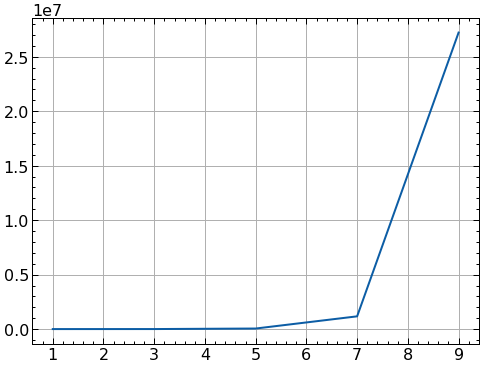

In [111]:
plt.plot(n_iters, np.sqrt(MSEs))
plt.grid()

Normalize this PET image based on the probability of certain events being detected.

In [18]:
PET_recon = PET_att_recon_MLEM/ det_matrix
PET_recon_smoothed = convolve(PET_recon, get_gaus_kernel(9,1), mode='same')

In [ ]:
psf_recon = functions.compute_recon_tomopy(sino_psf, thetas_psf, 'osem', num_iter=30)

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='Original')
plt.axvline(PET_og[T].mean(), color='blue', ls='--')
plt.hist(PET_att[T].ravel(), color='orange', histtype='step', bins=20, label='Attenuated')
plt.axvline(PET_att[T].mean(), color='orange', ls='--')
plt.hist(PET_att_recon[T].ravel(), color='green', histtype='step', bins=20, label='Recon [raw]')
plt.axvline(PET_att_recon[T].mean(), color='green', ls='--')
plt.hist(PET_recon[T].ravel(), color='red',  histtype='step', bins=20, label='Recon [adjusted]')
plt.axvline(PET_recon[T].mean(), color='red', ls='--')
plt.legend()
plt.show()

In [186]:
PET_recon_filtered = gaussian(PET_recon, sigma=0.9)

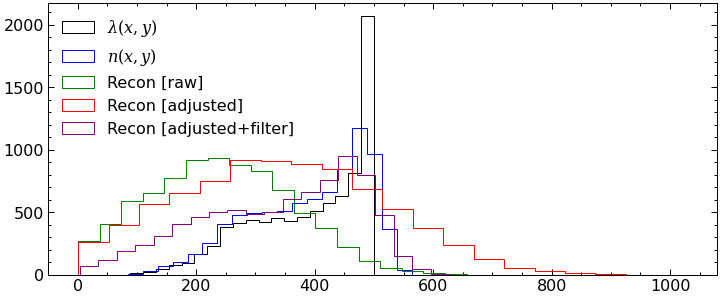

In [187]:
plt.figure(figsize=(12,5))
plt.hist(500*U[T].ravel(), color='black', histtype='step', bins=20, label='$\lambda(x,y)$')
plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='$n(x,y)$')
plt.hist(PET_att_recon[T].ravel(), color='green', histtype='step', bins=20, label='Recon [raw]')
plt.hist(PET_recon[T].ravel(), color='red',  histtype='step', bins=20, label='Recon [adjusted]')
plt.hist(PET_recon_filtered[T].ravel(), color='purple',  histtype='step', bins=20, label='Recon [adjusted+filter]')
plt.legend(loc='upper left')
plt.show()

In [277]:
lam = 500*U[T].ravel()
n = PET_og[T].ravel()
nD = PET_att_recon[T].ravel()
n_hat_raw = PET_recon[T].ravel()

# Fitler
PET_recon_filtered = gaussian(PET_recon, sigma=2)
n_hat_filt = PET_recon_filtered[T].ravel()

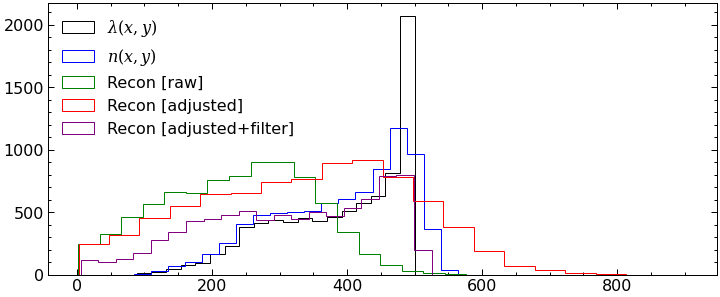

In [278]:
plt.figure(figsize=(12,5))
plt.hist(500*U[T].ravel(), color='black', histtype='step', bins=20, label='$\lambda(x,y)$')
plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='$n(x,y)$')
plt.hist(PET_att_recon[T].ravel(), color='green', histtype='step', bins=20, label='Recon [raw]')
plt.hist(PET_recon[T].ravel(), color='red',  histtype='step', bins=20, label='Recon [adjusted]')
plt.hist(PET_recon_filtered[T].ravel(), color='purple',  histtype='step', bins=20, label='Recon [adjusted+filter]')
plt.legend(loc='upper left')
plt.show()

In [190]:
from skimage import color, data, restoration

In [191]:
def get_gaus_kernel(n, sig):
    xv, yv = np.meshgrid(np.arange(n), np.arange(n))
    xv = xv - xv.max()/2
    yv = yv -  yv.max()/2
    gaus_kernel = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(xv**2+yv**2)/(2*sig**2))
    return gaus_kernel/gaus_kernel.sum()
    

In [192]:
g = get_gaus_kernel(10, 5)
new = restoration.wiener(PET_recon, g, 1, clip=False)

In [193]:
n_hat_deconv = new[T].ravel()

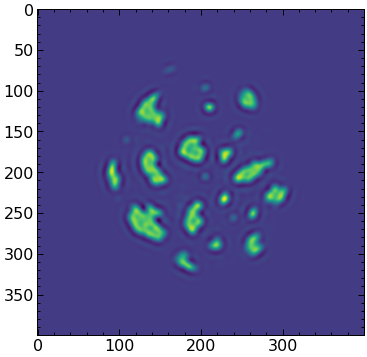

In [194]:
plt.imshow(new)

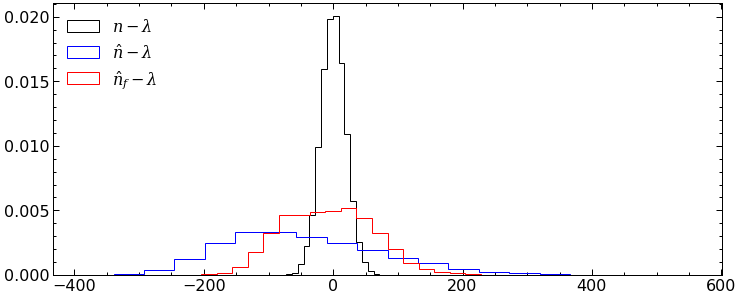

In [195]:
plt.figure(figsize=(12,5))
plt.hist(n-lam, color='black', histtype='step', bins=20, label='$n-\lambda$', density=True)
plt.hist(n_hat_raw-lam, color='blue', histtype='step', bins=20, label='$\hat{n}-\lambda$', density=True)
plt.hist(n_hat_deconv-lam, color='red', histtype='step', bins=20, label='$\hat{n}_{f}-\lambda$', density=True)
#plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='$n(x,y)$')
plt.legend(loc='upper left')
plt.show()

In [196]:
def compute_SUV_max(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].max())
        SUV_recon_filtered.append(PET_recon_filtered[T].max())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

def compute_SUV_mean(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].mean())
        SUV_recon_filtered.append(PET_recon_filtered[T].mean())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

In [197]:
tumour_size, SUV_og_max, SUV_recon_max = compute_SUV_max(PET_og, new, Ts)
tumour_size, SUV_og_mean, SUV_recon_mean = compute_SUV_mean(PET_og, new, Ts)

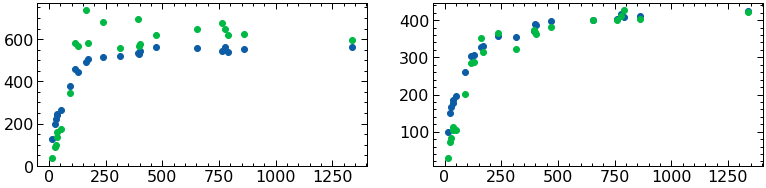

In [198]:
fig, ax = plt.subplots(1,2,figsize=(13,3))
ax[0].scatter(tumour_size, SUV_og_max)
ax[0].scatter(tumour_size, SUV_recon_max)
ax[1].scatter(tumour_size, SUV_og_mean)
ax[1].scatter(tumour_size, SUV_recon_mean)

# Results from All Algorithms

In [104]:
def get_iters_MSEs(df, name):
    iters = np.array(df[name][0].strip('][').replace('\n', '').split()).astype(float)
    MSE = np.array(df[name][1].strip('][').replace('\n', '').split()).astype(float)
    iter_best = int(df[name][3])
    MSE_best = MSE[iters==iter_best][0]
    return iters, MSE, MSE_best

def info_dict(df):
    algos = list(df.columns[1:])
    di = {}
    for algo in algos:
        iters, mses, mse_best = get_iters_MSEs(df, algo)
        di[algo] = {'iters': iters, 'mses': mses, 'mse_best': mse_best}

    rmse_best = []
    for algo in algos:
        rmse_best.append(np.sqrt(di[algo]['mse_best']))
    return algos, rmse_best, di

In [118]:
df1 = pd.read_csv('all_algos_P1.csv')
algos1, rmse_best1, di1 = info_dict(df1)
df2 = pd.read_csv('all_algos_P2.csv')
algos2, rmse_best2, di2 = info_dict(df2)
df3 = pd.read_csv('all_algos_P3.csv')
algos3, rmse_best3, di3 = info_dict(df3)
df4 = pd.read_csv('all_algos_P4.csv')
algos4, rmse_best4, di4 = info_dict(df4)

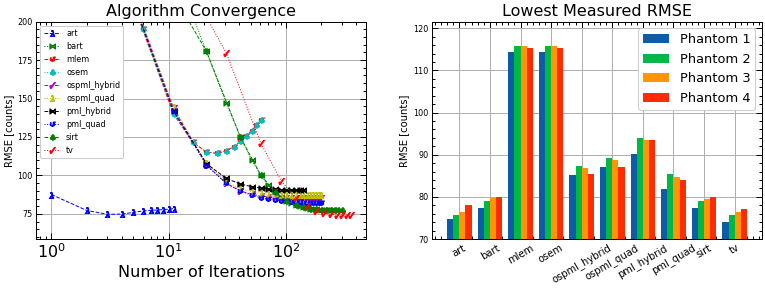

In [124]:
linestyles = ['--', ':']

styles = [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')

plt.figure(figsize=(13,4), facecolor='white')
plt
plt.subplot(121)
for i, algo in enumerate(di1):
    plt.plot(di1[algo]['iters'],np.sqrt(di1[algo]['mses']), label=algo, 
             marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1)
plt.ylim(top=200)
plt.yticks(fontsize=8)
plt.semilogx()
plt.legend(ncol=1, fontsize=8, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.grid()
plt.xlabel('Number of Iterations')
plt.yticks(fontsize=8)
plt.ylabel('RMSE [counts]', fontsize=10)
plt.title('Algorithm Convergence')

x = np.arange(len(algos1))
width = 0.2  # the width of the bars

plt.subplot(122)
plt.grid(zorder=1)
plt.bar(x-(3/2)*width, rmse_best1, width, zorder=2, label='Phantom 1')
plt.bar(x-(1/2)*width, rmse_best2, width, zorder=2, label='Phantom 2')
plt.bar(x+(1/2)*width, rmse_best3, width, zorder=2, label='Phantom 3')
plt.bar(x+(3/2)*width, rmse_best4, width, zorder=2, label='Phantom 4')
plt.ylim(bottom=70)
plt.grid(zorder=-1000000)
plt.xticks(x,  algos1, rotation='30', fontsize=10)
plt.yticks(fontsize=8)
plt.ylabel('RMSE [counts]', fontsize=10)
plt.title('Lowest Measured RMSE')
plt.legend(ncol=1, fontsize=13, facecolor='white', framealpha=1, frameon=True, loc='upper right')

plt.savefig('images/algocomapre.png', dpi=200)
plt.show()

In [128]:
rmse_best4

[78.00000325480762,
 80.03993222004877,
 115.28984294481452,
 115.28984294481452,
 85.37455948302164,
 87.09940967681699,
 93.46176399148477,
 84.09671421191199,
 80.04164994601248,
 77.15371047869311]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()


Get pictures of all recon

In [3]:
algos = ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']
iterations = [10, 250, 60, 60, 200, 200, 140, 200, 300, 360]

lam = 500
n = 400

A = imageio.imread('images/phantom1.png').sum(axis=2)
A_norm = functions.normalize_phantom(A)
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

U = functions.get_tumour_dist(T, sigma=3)

dfile = np.load('tumour_dist_P1.npz')
PET_og, dpoints, dangles, prob_of_detections = dfile['PET_og'], dfile['dpoints'], dfile['dangles'], dfile['prob_of_detections']

PET_att, mask_att = functions.get_attenuated_PET(dpoints, dangles, prob_of_detections, n=n)

sino, rs, thetas =  functions.get_sinogram(dpoints, dangles)
sino_att, _, _ =  functions.get_sinogram(dpoints, dangles, mask=mask_att)

det_matrix = functions.compute_detection_matrix(A_norm, n=400, spacing=4)

info = {}
for algo, iteration in zip(algos, iterations):
    print(algo)
    im = functions.compute_recon_tomopy(sino_att, thetas, algo, num_iter=iteration);
    im = im/det_matrix
    info[algo] = im

art
Reconstructing 1 slice groups with 1 master threads...
bart
Reconstructing 1 slice groups with 1 master threads...
mlem
Reconstructing 1 slice groups with 1 master threads...
osem
Reconstructing 1 slice groups with 1 master threads...
ospml_hybrid
Reconstructing 1 slice groups with 1 master threads...
ospml_quad
Reconstructing 1 slice groups with 1 master threads...
pml_hybrid
Reconstructing 1 slice groups with 1 master threads...
pml_quad
Reconstructing 1 slice groups with 1 master threads...
sirt
Reconstructing 1 slice groups with 1 master threads...
tv
Reconstructing 1 slice groups with 1 master threads...


<ipython-input-4-b6df6b52d0c4>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma"))
  cmap.set_under(color='black')


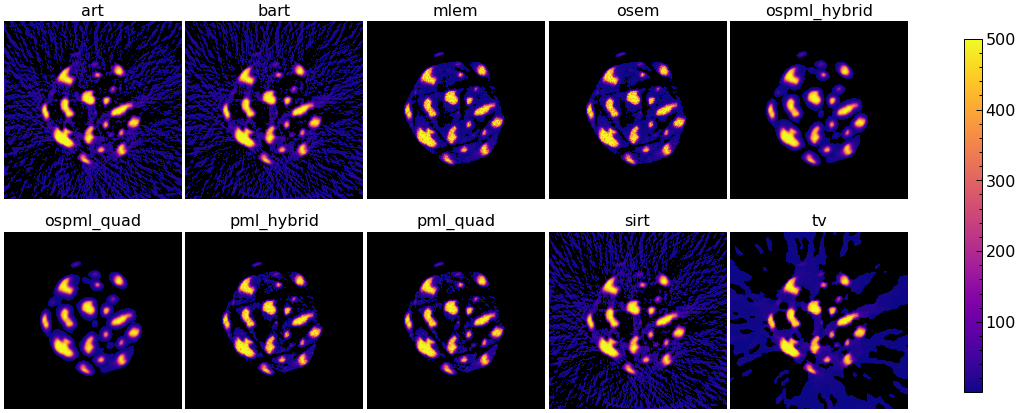

In [4]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.imshow(info[algo], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('images/recon.png', dpi=200)

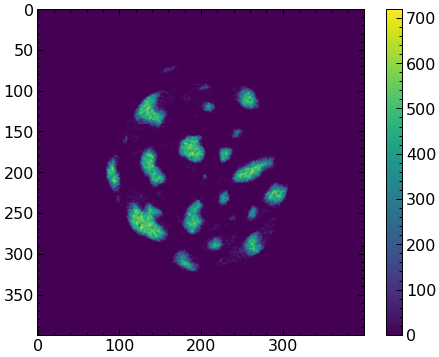

In [5]:
plt.imshow(info['pml_hybrid'])
plt.colorbar()

# DEconv MEthod From Paper

Compute matrix $\Delta M$ where $\Delta M_{i,j} = \sum

In [6]:
import importlib
import paper_f_old as pfo 
import paper_f_new as pfn 
importlib.reload(pfo)
importlib.reload(pfn)

<module 'paper_f_new' from 'C:\\Users\\lukep\\Documents\\videos\\School\\Phys 541\\final_proj\\paper_f_new.py'>

Make sure the gradient is actually computing the gradient

In [7]:
lam=0.3
i = gaussian(info['pml_quad'], sigma=2)
l = T.astype(float)
h = get_gaus_kernel(9, 2)
o = i.copy().ravel()

Get gradient

In [8]:
o_test = o.copy()
do = 0.000001
o_test[47735]+=do
print((pfn.f(o_test, i, l, h, lam) - pfn.f(o,i,l,h, lam))/do)
grad = pfn.gradf(o,i,l,h, lam)
print(grad[47735])

-27.85399556159973
-27.86777176399237


In [9]:
grad_samp = pfn.gradf(o, i, l, h, lam)
grad_samp = grad_samp.reshape(400,400)

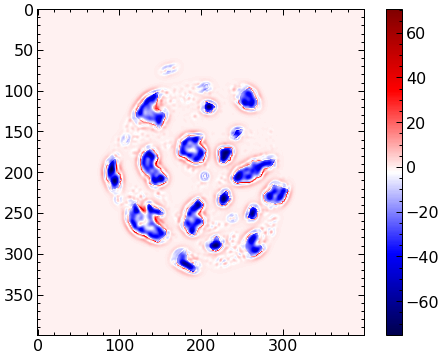

In [10]:
cmap = mpl.cm.get_cmap("seismic")
plt.imshow(grad_samp, cmap=cmap)
plt.colorbar()

In [11]:
res_o = optimize.minimize(pfo.f,o,args=(i,l,h,lam), jac=pfo.gradf, method='CG',
                       options=dict(maxiter=100, gtol=160000*1e-5))
'''
res_n = optimize.minimize(pfn.f,o,args=(i,l,h,lam), jac=pfn.gradf, method='CG',
                       options=dict(maxiter=100, gtol=160000*1e-5))
'''

"\nres_n = optimize.minimize(pfn.f,o,args=(i,l,h,lam), jac=pfn.gradf, method='CG',\n                       options=dict(maxiter=100, gtol=160000*1e-5))\n"

<ipython-input-12-48be90993a46>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma"))
  cmap.set_under(color='black')


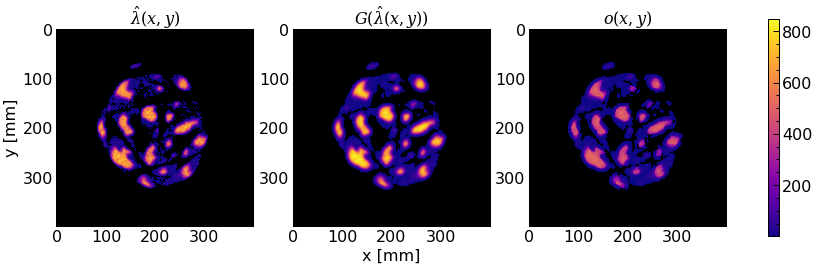

In [12]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(1,3,figsize=(15,8))
axes[0].imshow(info['pml_quad'], vmin=1, cmap=cmap)
axes[0].set_title('$\hat{\lambda}(x,y)}$')
axes[0].set_ylabel('y [mm]')
axes[1].imshow(i.reshape(400,400), vmin=1, cmap=cmap)
axes[1].set_title('$G(\hat{\lambda}(x,y))$')
axes[1].set_xlabel('x [mm]')
pcm = axes[2].imshow(res_o.x.reshape(400,400), vmin=1, cmap=cmap)
axes[2].set_title('$o(x,y)})$')
#[a.set_axis_off() for a in axes]
fig.colorbar(pcm, ax=axes, shrink=0.5)
plt.savefig('images/PVC_chain.png', dpi=200)

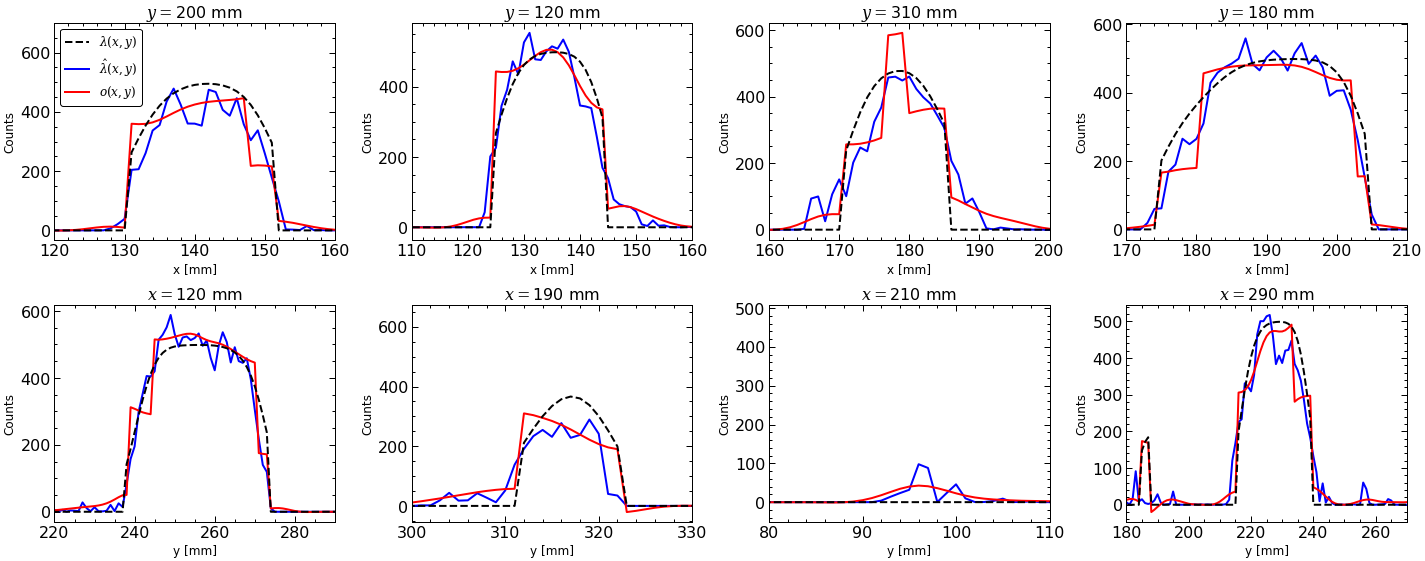

In [13]:
slics = [200,120,310,180,120,190,210,290]
rngs = [(120,160),(110,160),(160,200),(170,210),(220,290),(300,330),(80,110),(180,270)]
fig, ax = plt.subplots(2,4,figsize=(20,8))
for i, (slic, rng) in enumerate(zip(slics, rngs)):
    a = ax.ravel()[i]
    if i<4:
        a.plot(500*U[slic], ls='--', color='k', label='$\lambda(x,y)$', zorder=1000)
        a.plot(info['pml_quad'][slic], label='$\hat{\lambda}(x,y)$', color='blue')
        a.plot(res_o.x.reshape(400,400)[slic], label='$o(x,y)$', color='red')
        a.set_xlabel('x [mm]', fontsize=12)
        a.set_ylabel('Counts', fontsize=12)
        a.set_title('$y=${} mm'.format(slic))
    elif i>=4:
        a.plot(500*U[:,slic], ls='--', color='k', label='$\lambda(x,y)$', zorder=1000)
        a.plot(info['pml_quad'][:,slic], label='$\hat{\lambda}(x,y)$', color='blue')
        a.plot(res_o.x.reshape(400,400)[:,slic], label='$o(x,y)$', color='red')  
        
        a.set_xlabel('y [mm]', fontsize=12)
        a.set_ylabel('Counts', fontsize=12)
        a.set_title('$x=${} mm'.format(slic))
        
        
    a.set_xlim(rng)
ax[0,0].legend(loc='upper left', fontsize=12, facecolor='white', framealpha=1, frameon=True, edgecolor='k')
ax[0,0].set_ylim(top=700)
fig.tight_layout()
plt.savefig('images/pvc_results.png', dpi=200)

In [14]:
lam = U[T].ravel()*500
n_hat_raw = gaussian(info['pml_quad'], sigma=2)[T].ravel()
n_hat_paper = res_o.x.reshape(400,400)[T].ravel()
#n_hat_paper *= np.sum(n_hat_raw)/np.sum(n_hat_paper)

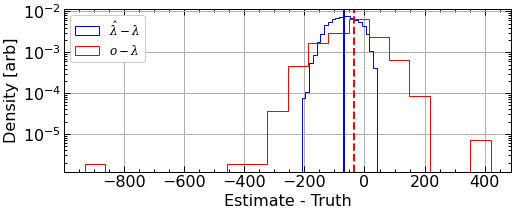

In [15]:
plt.figure(figsize=(8,3))
plt.hist(n_hat_raw-lam, color='blue', histtype='step', bins=20, label='$\hat{\lambda}-\lambda$', density=True)
plt.hist(n_hat_paper-lam, color='red', histtype='step', bins=20, label='$o-\lambda$', density=True)
plt.axvline(np.mean(n_hat_raw-lam), color='blue')
plt.axvline(np.mean(n_hat_paper-lam), color='red', ls='--')
plt.legend(ncol=1, fontsize=12, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.xlabel('Estimate - Truth')
plt.ylabel('Density [arb]')
plt.grid()
plt.semilogy()
plt.savefig('images/PVC_hist.png', dpi=200)
plt.show()

In [16]:
def compute_SUV_max(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].max())
        SUV_recon_filtered.append(PET_recon_filtered[T].max())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

def compute_SUV_mean(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].mean())
        SUV_recon_filtered.append(PET_recon_filtered[T].mean())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

In [17]:
tumour_size, SUV_og_max_i, SUV_recon_max_i = compute_SUV_max(PET_og, info['pml_quad'], Ts)
tumour_size, SUV_og_mean_i, SUV_recon_mean_i = compute_SUV_mean(PET_og, info['pml_quad'], Ts)
tumour_size, SUV_og_max, SUV_recon_max = compute_SUV_max(PET_og, res_o.x.reshape(400,400), Ts)
tumour_size, SUV_og_mean, SUV_recon_mean = compute_SUV_mean(PET_og, res_o.x.reshape(400,400), Ts)

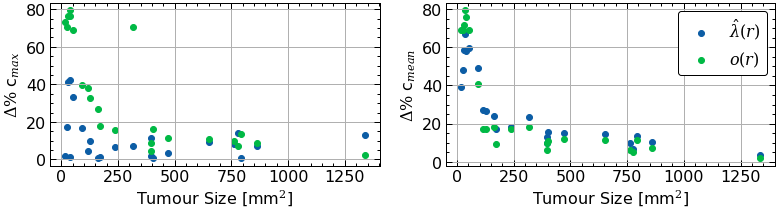

In [18]:
fig, ax = plt.subplots(1,2,figsize=(13,3))
ax[0].scatter(tumour_size, 100*np.abs(SUV_og_max - SUV_recon_max_i)/SUV_og_max, label='$\hat{\lambda}(r)$')
ax[0].scatter(tumour_size, 100*np.abs(SUV_og_max - SUV_recon_max)/SUV_og_max, label='$o(r)$')
ax[1].scatter(tumour_size, 100*np.abs(SUV_og_mean - SUV_recon_mean_i)/SUV_og_mean, label='$\hat{\lambda}(r)$')
ax[1].scatter(tumour_size, 100*np.abs(SUV_og_mean - SUV_recon_mean)/SUV_og_mean, label='$o(r)$')
ax[0].set_xlabel('Tumour Size [mm$^2$]')
ax[1].set_xlabel('Tumour Size [mm$^2$]')
ax[0].set_ylabel(r'$\Delta \%$ c$_{max}$')
ax[1].set_ylabel(r'$\Delta \%$ c$_{mean}$')
ax[0].grid()
ax[1].grid()
ax[1].legend(loc='upper right', fontsize=16, facecolor='white', framealpha=1, frameon=True, edgecolor='k')
plt.savefig('images/suv.png', dpi=200)
plt.show()